# Locating a fox transmitter from two bearing measurements
(c) 2019 Michael Robinson

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pysheaf as ps
import networkx as nx
import generate_data
import fox_sheaf
import copy

Create the sheaf from two reception reports of a transmitter.  This establishes the sheaf structure.  We'll overwrite the data in the assignment repeatedly once it's built

In [2]:
fox=generate_data.Transmitter(location=np.array([0.5,0.5]),power=1.0,identity='A')
rx1=generate_data.Receiver()
rx1.add_reception(time=0.0,location=np.array([1,0]),transmitter=fox)
rx2=generate_data.Receiver()
rx2.add_reception(time=0.0,location=np.array([1,1]),transmitter=fox)

bearing_sheaf=fox_sheaf.FoxSheaf(['bearing','bearing'],[rx1,rx2])

Here's what the sheaf looks like.  Note that the stalk over cell `0` is underconstrained, so it's presence won't impact our calculations

([], <a list of 0 Text yticklabel objects>)

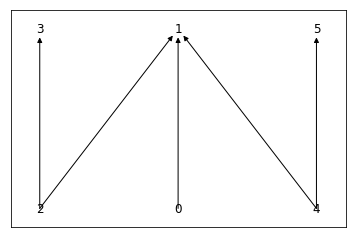

In [3]:
pos=nx.nx_agraph.pygraphviz_layout(bearing_sheaf,prog='dot',args='-Grankdir=BT')
nx.draw_networkx_labels(bearing_sheaf,pos)
nx.draw_networkx_edges(bearing_sheaf,pos)
plt.xticks([])
plt.yticks([])

## Computing consistency radius as a function of fox location

The end goal is an image whose coordinates are possible fox locations, and whose pixels are colored by consistency radius.  Preallocate space for the image.  

In [4]:
crmat=np.zeros((50,50)) # If you want a nicer image, increase the size of crmat
xs=np.linspace(-1,2,crmat.shape[1])
ys=np.linspace(-1,2,crmat.shape[0])

Compute the image!  Basically, scan over all proposed fox locations, computing consistency radius as we go

In [5]:
for j in range(len(xs)):
    for k in range(len(ys)):
        # Proposed fox location
        fx=xs[j]
        fy=ys[k]
        
        # Overwrite the assignment
        astest=copy.deepcopy(bearing_sheaf)
        astest.GetCell(0).SetDataAssignment(ps.Assignment('foxloc_power',np.array([fx,fy,1])))
        astest.GetCell(1).SetDataAssignment(ps.Assignment('foxloc',np.array([fx,fy])))
        astest.GetCell(2).SetDataAssignment(ps.Assignment('foxloc_rxloc',np.array([fx,fy,1,0])))
        astest.GetCell(4).SetDataAssignment(ps.Assignment('foxloc_rxloc',np.array([fx,fy,1,1])))
        
        # Propagate the assignment
        for c in astest.GetCellIndexList(): astest.MaximallyExtendCell(c)
        
        # Store the consistency radius
        crmat[k,j]=astest.ComputeConsistencyRadius()

Plotting!

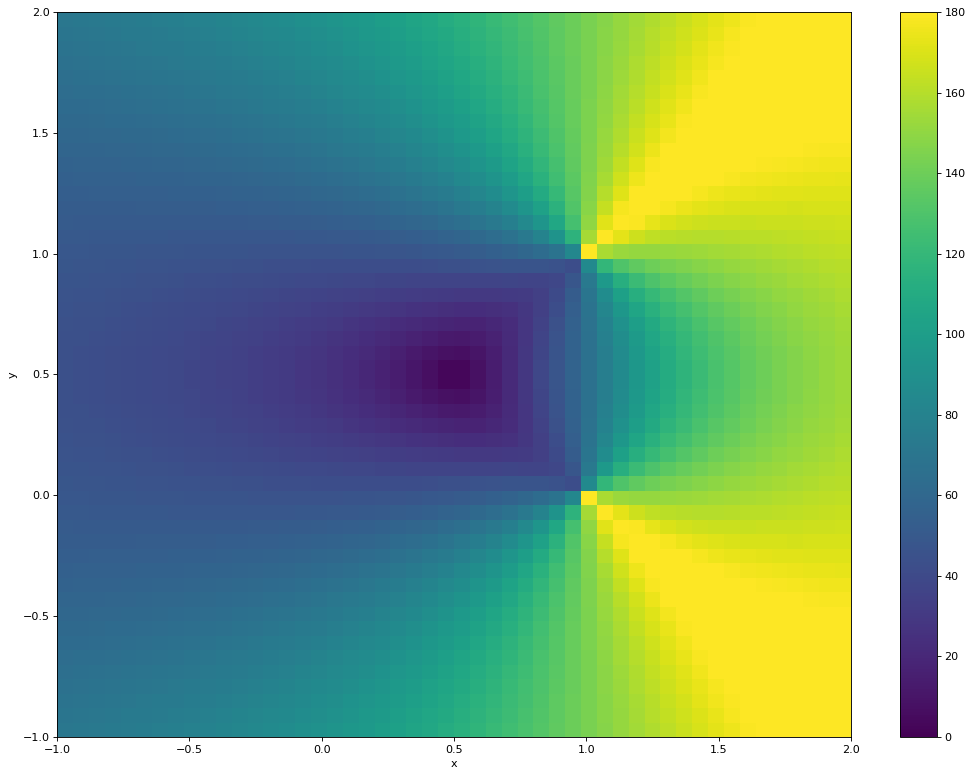

In [6]:
plt.figure(figsize=(16,12),dpi=80)
plt.imshow(crmat,origin='lower',extent=[-1,2,-1,2],aspect='auto',interpolation='nearest',vmin=0,vmax=180)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()

## Computing the consistency filtration

Build an assignment in which Sensor 1 measures a bearing of -180 degrees, while Sensor 2 measures a bearing of 0.  (This can't actually ever happen with one fox!)

In [7]:
bearing_sheaf.GetCell(0).SetDataAssignment(ps.Assignment('foxloc_power',np.array([0,0,1])))
bearing_sheaf.GetCell(1).SetDataAssignment(ps.Assignment('foxloc',np.array([0,0])))
bearing_sheaf.GetCell(2).SetDataAssignment(ps.Assignment('foxloc_rxloc',np.array([0,0,1,0])))
bearing_sheaf.GetCell(3).SetDataAssignment(ps.Assignment('bearing_rxloc',np.array([1,0,180])))
bearing_sheaf.GetCell(4).SetDataAssignment(ps.Assignment('foxloc_rxloc',np.array([0,0,1,1])))
bearing_sheaf.GetCell(5).SetDataAssignment(ps.Assignment('bearing_rxloc',np.array([1,1,0])))

for c in bearing_sheaf.GetCellIndexList(): bearing_sheaf.MaximallyExtendCell(c)
bearing_sheaf.ComputeConsistencyRadius()

162.24980739587951

The consistency radius for this assignment isn't zero, which indicates a problem with the measurements.  Let's plot the resulting consistency radius as a function of fox position to explore the situation a bit more.

In [8]:
crmat=np.zeros((50,50)) # If you want a nicer image, increase the size of crmat
xs=np.linspace(-1,2,crmat.shape[1])
ys=np.linspace(-1,2,crmat.shape[0])

In [9]:
for j in range(len(xs)):
    for k in range(len(ys)):
        # Proposed fox location
        fx=xs[j]
        fy=ys[k]
        
        # Overwrite the assignment
        astest=copy.deepcopy(bearing_sheaf)
        astest.GetCell(0).SetDataAssignment(ps.Assignment('foxloc_power',np.array([fx,fy,1])))
        astest.GetCell(1).SetDataAssignment(ps.Assignment('foxloc',np.array([fx,fy])))
        astest.GetCell(2).SetDataAssignment(ps.Assignment('foxloc_rxloc',np.array([fx,fy,1,0])))
        astest.GetCell(4).SetDataAssignment(ps.Assignment('foxloc_rxloc',np.array([fx,fy,1,1])))

        # Propagate the assignment
        for c in astest.GetCellIndexList(): astest.MaximallyExtendCell(c)
        
        # Store the consistency radius
        crmat[k,j]=astest.ComputeConsistencyRadius()

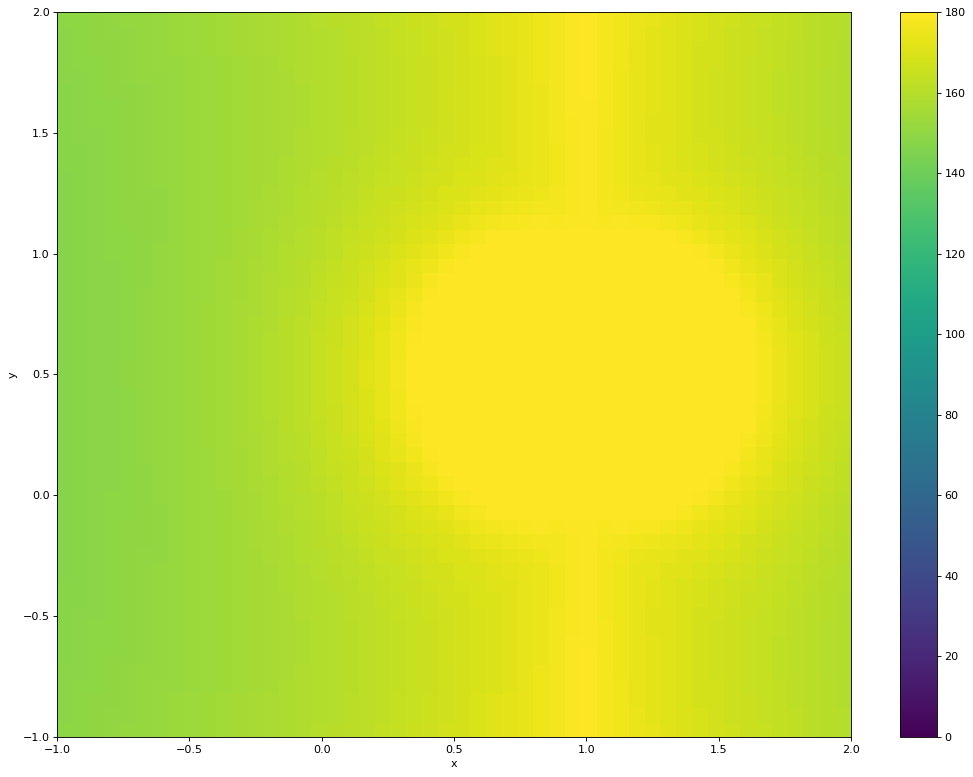

In [10]:
plt.figure(figsize=(16,12),dpi=80)
plt.imshow(crmat,origin='lower',extent=[-1,2,-1,2],aspect='auto',interpolation='nearest',vmin=0,vmax=180)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()

Now, let's compute the consistency filtration of the original assignment -- when the transmitter is assumed to be at `(0,0)`.  We need to give this a list of thresholds, which I've manually tuned a bit.  Thresholds are split just above/below where something interesting happens. 

In [11]:
consistency_filtration=bearing_sheaf.ConsistencyFiltration([1,45,90,90.1,135,135.1,180])

The output of the consistency filtration is a `frozenset` of cell labels in the open set, followed by the minimum and maximum thresholds over which that open set is present.  The minimum threshold is just above the local consistency radius of that open set. The maximum threshold is the threshold above which that open set is contained in some larger open set that's also consistent to that level.

The open sets listed are all connected open sets in the Alexandrov topology of the partial order.  I've found that connectivity leads to open sets that are much easier to interpret.

In order to render the consistency filtration, it's useful to encode it as a NetworkX directed graph in which the nodes are open sets and the edges are inclusion relations

In [12]:
G=nx.DiGraph()
pos=dict()
labels=dict()
for o,b,d in consistency_filtration:
    G.add_node(o)
    labels[o]=str(list(o))
for o1,b1,d1 in consistency_filtration:
    for o2,b2,d2 in consistency_filtration:
        if o2 != o1 and set(o1).issubset(o2):
            G.add_edge(o1,o2)

G2=nx.algorithms.dag.transitive_reduction(G)

Now, let's render it.  Initial positions are chosen by GraphViz, but then they're tweaked so that they're in terms of local consistency radius

([], <a list of 0 Text xticklabel objects>)

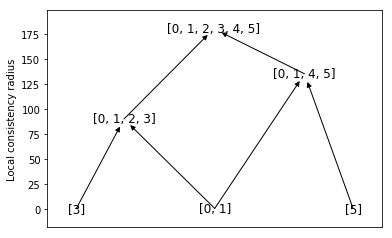

In [13]:
pos=nx.nx_agraph.pygraphviz_layout(G2,prog='dot',args='-Grankdir=BT')
for o,b,d in consistency_filtration:
    pos[o]=np.array([pos[o][0],b])
nx.draw_networkx_labels(G2,pos,labels=labels)
nx.draw_networkx_edges(G2,pos)
plt.ylabel('Local consistency radius')
plt.xticks([])